# Debugging xy shift in WN regen

In [1]:
import retinanalysis as ra
import numpy as np
import matplotlib.pyplot as plt
import mat73
from scipy.io import loadmat
import os
print(ra.settings.ANALYSIS_DIR)
import sys
sys.path.append('/home/vyomr/Desktop/gitrepos/retinanalysis/src/retinanalysis/utils/')
import regen
import importlib
importlib.reload(regen)
import cv2

Could not connect to DataJoint database: (2003, "Can't connect to MySQL server on '127.0.0.1' ([Errno 111] Connection refused)")
/run/user/1001/gvfs/smb-share:server=128.95.10.105,share=data/analysis


In [2]:
exp_name = '20250514C'
datafile_name = 'data001'
e_idx = 9
# str_mat = '/Volumes/Vyom MEA/data/noise_regen_full.mat'
# str_mat = os.path.join(ra.settings.ANALYSIS_DIR, exp_name, 'chunk1', 'kilosort2.5', 'noise_regen_full.mat')
str_mat = os.path.join(ra.settings.ANALYSIS_DIR, exp_name, 'chunk1', 'kilosort2.5', 'epoch10_20250514C_100frames.mat')
# d_mat = mat73.loadmat(str_mat)
d_mat = loadmat(str_mat)

In [3]:
# d_mat['frames'] is array of arrays of shape (1, 101), inner arrays are (ht, wt, ch)
# make into 4darray
s_frames = np.zeros((101,1140,1824,3))
for i in range(100):
    s_frames[i,:,:,:] = d_mat['frames_out'][0,i]
s_frames = s_frames.astype(np.float32)

In [4]:
# Clip preframes
s_frames = np.array(s_frames[16:], dtype=np.float32) / 255
# idk why stage regen is y-flipped, let's assume yflipping is right thing to do
s_frames = s_frames[:,::-1,...]
s_frames.shape

(85, 1140, 1824, 3)

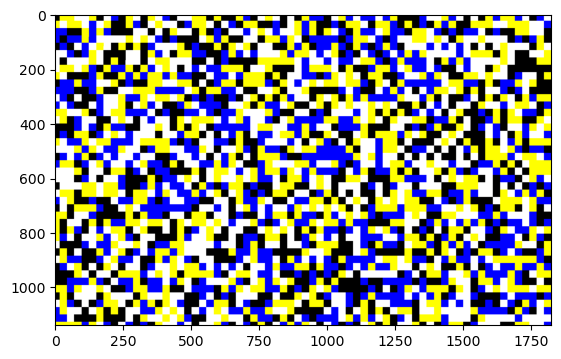

In [5]:
plt.imshow((d_mat['frames_out'][0,16]))

In [6]:
import os
str_pkl = os.path.join(ra.settings.ANALYSIS_DIR, exp_name, 'chunk1', 'kilosort2.5', 'data001_sb.pkl')
# sb = ra.MEAStimBlock(exp_name, datafile_name)
# sb.export_to_pkl(str_pkl)
sb = ra.MEAStimBlock(pkl_file=str_pkl)

Initializing StimBlock for None block None from pickle file
StimBlock loaded from /run/user/1001/gvfs/smb-share:server=128.95.10.105,share=data/analysis/20250514C/chunk1/kilosort2.5/data001_sb.pkl


Idk why 3.34 in sta_analysis but 3.37 in rig and epoch params, and yet 3.34 gives correct numXStix

OK key is um2pix rounds!

In [7]:
import sys
sys.path.append('/home/vyomr/Desktop/gitrepos/retinanalysis/src/retinanalysis/utils/')
import regen
import importlib
importlib.reload(regen)
d_wn = regen.make_spatial_noise(sb.df_epochs.loc[[e_idx]])
r_frames = d_wn['frames']

  0%|          | 0/1 [00:00<?, ?it/s]

numXStixels: 69.0, numYStixels: 44.0, numXChecks: 203.0, numYChecks: 127.0
chromaticClass: BY, unique_frames: 10789, repeat_frames: 30
stepsPerStixel: 3.0, seed: 542274688.0, frameDwell: 1.0
gaussianFilter: 0, filterSdStixels: 1.0
Grid size: 9 pix, Stixel size: 27.0 pix
gridValues: (100, 3036)
gridValues: (100, 44, 69)
fullGrid: (100, 1188, 1863)
frameValues: (100, 1140, 1824)
Cropping fullGrid by [24.  2.] pixels on top and left
fullGrid: (100, 1188, 1863)


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


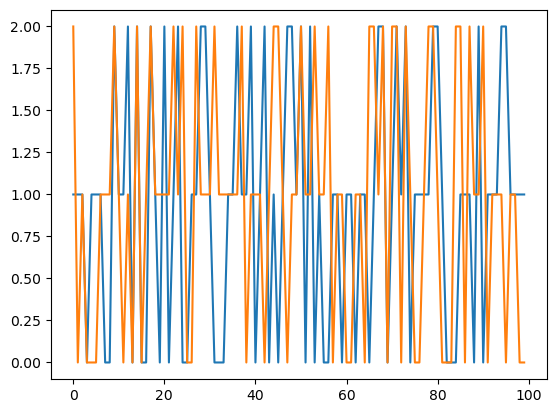

In [8]:
plt.plot(d_wn['steps'][0,:100,0])
plt.plot(d_wn['steps'][0,:100,1])

In [9]:
r_frames = (r_frames[0]+1)/2

(np.float64(-0.5), np.float64(1823.5), np.float64(1139.5), np.float64(-0.5))

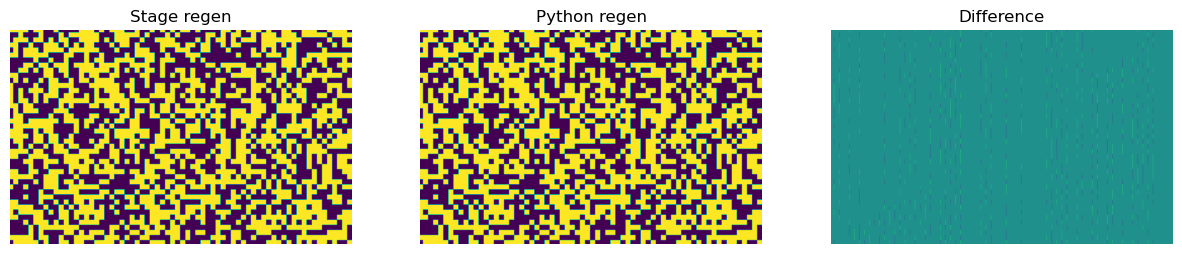

In [10]:
import cv2
f, axs = plt.subplots(ncols=3, figsize=(15,10))
ls_f = [s_frames, r_frames]
ls_titles = ['Stage regen', 'Python regen']
i_frame = 0 # 3 has 0 offset

ax = axs[0]
f = ls_f[0][i_frame]
f = f[...,0]
# f = cv2.resize(f, (203, 127), interpolation=cv2.INTER_NEAREST)
im=ax.imshow(f)
ax.set_title(ls_titles[0])
ax.axis('off')

ax = axs[1]
f = ls_f[1][i_frame]
f = f[...,0]
# f = cv2.resize(f, (203, 127), interpolation=cv2.INTER_NEAREST)
im=ax.imshow(f)
ax.set_title(ls_titles[1])
ax.axis('off')

ax = axs[2]
f = ls_f[0][i_frame] - ls_f[1][i_frame]
f = f[...,0]
# Scale difference to 0, 1
f = (f - f.min()) / (f.max() - f.min())
# f = cv2.resize(f, (203, 127), interpolation=cv2.INTER_NEAREST)
im=ax.imshow(f, cmap='viridis')#, vmin=-0.5, vmax=0.5)
ax.set_title('Difference')
ax.axis('off')

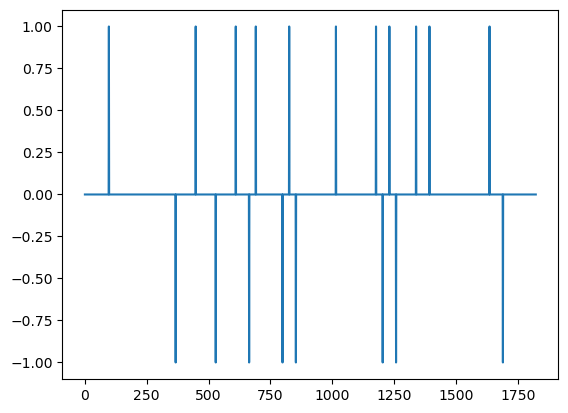

In [11]:
# plt.plot(s_frames[0,0,:600,0])
# plt.plot(r_frames[0,0,:600,0])
plt.plot(s_frames[0,0,:,0] - r_frames[0,0,:,0])

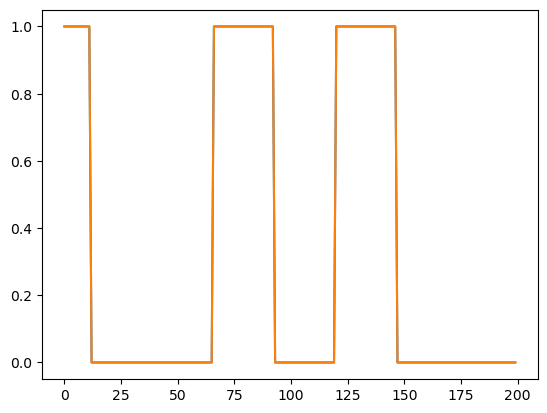

In [12]:
plt.plot(s_frames[0,:200, 0,0])
plt.plot(r_frames[0,:200, 0,0])


In [13]:
r_frames.shape, s_frames.shape

((50, 1140, 1824, 3), (85, 1140, 1824, 3))

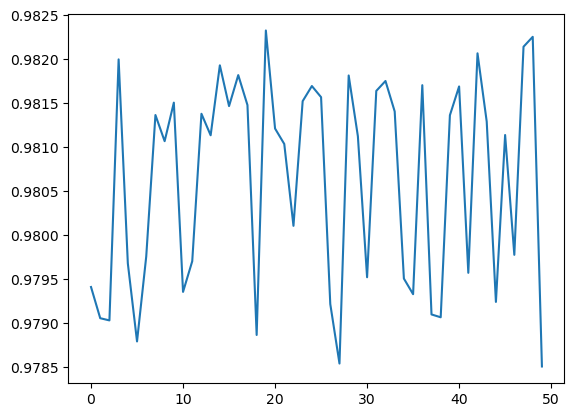

In [14]:
import cv2
ls_corrs = []
for t in range(50):
    # ds = cv2.resize(r_frames[t], (s_frames.shape[2], s_frames.shape[1]), interpolation=cv2.INTER_NEAREST)
    r = np.corrcoef(s_frames[t].flatten(), r_frames[t].flatten())[0,1]
    ls_corrs.append(r)
plt.plot(ls_corrs)